# 1. BTC/USD Dataset (Data split 7:3)

In [1]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../Dataset/BTC_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [3]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [4]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,3823.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN
2019-03-04,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN
2019-03-05,3857.5,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN


In [5]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.7)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [6]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [7]:
split_size1 = int(0.7 * len(price))

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [8]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [9]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 178750.9531 - mae: 178750.9531 - mse: 210347278336.0000 - val_loss: 130029.7734 - val_mae: 130029.7734 - val_mse: 20284170240.0000
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - loss: 76085.6797 - mae: 76085.6797 - mse: 10345307136.0000 - val_loss: 19835.6406 - val_mae: 19835.6406 - val_mse: 478956544.0000
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step - loss: 11912.0195 - mae: 11912.0195 - mse: 259405488.0000 - val_loss: 28788.7988 - val_mae: 28788.7988 - val_mse: 1002410432.0000
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step - loss: 16675.0332 - mae: 16675.0332 - mse: 533177120.0000 - val_loss: 1274.4309 - val_mae: 1274.4309 - val_mse: 3402787.0000
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - loss: 1476.8835 - mae: 1476.8835 - mse: 5356391.5000 - val_loss: 10767.5479 - val_mae: 10767.5479 - val_mse: 140840688.0000
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step - loss: 6467.5469 - mae: 6467.5469 - mse:

In [10]:
model_preds1 = model.predict(X_test).reshape(-1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 1.8714319647513689
RMSE: 1156.1674200435564
MAE: 708.0453972261541


In [12]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [13]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicting on: 
 Date
2024-05-26    68520.1
2024-05-27    69440.0
2024-05-28    68374.0
2024-05-29    67652.4
2024-05-30    68352.2
2024-05-31    67548.0
2024-06-01    67768.5
Name: Price, dtype: float64 -> Prediction: 68131.5234375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting on: 
 [69440.        68374.        67652.4       68352.2       67548.
 67768.5       68131.5234375] -> Prediction: 68597.0546875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicting on: 
 [68374.        67652.4       68352.2       67548.        67768.5
 68131.5234375 68597.0546875] -> Prediction: 67880.7578125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting on: 
 [67652.4       68352.2       67548.        67768.5       68131.5234375
 68597.0546875 67880.7578125] -> Prediction: 67576.2421875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting on: 
 [68352.2       67548.        67768.5       68131.5234375 68597.0546875
 67880.7578125 67576.2421875] -> Prediction: 67721.773437

In [14]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [15]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

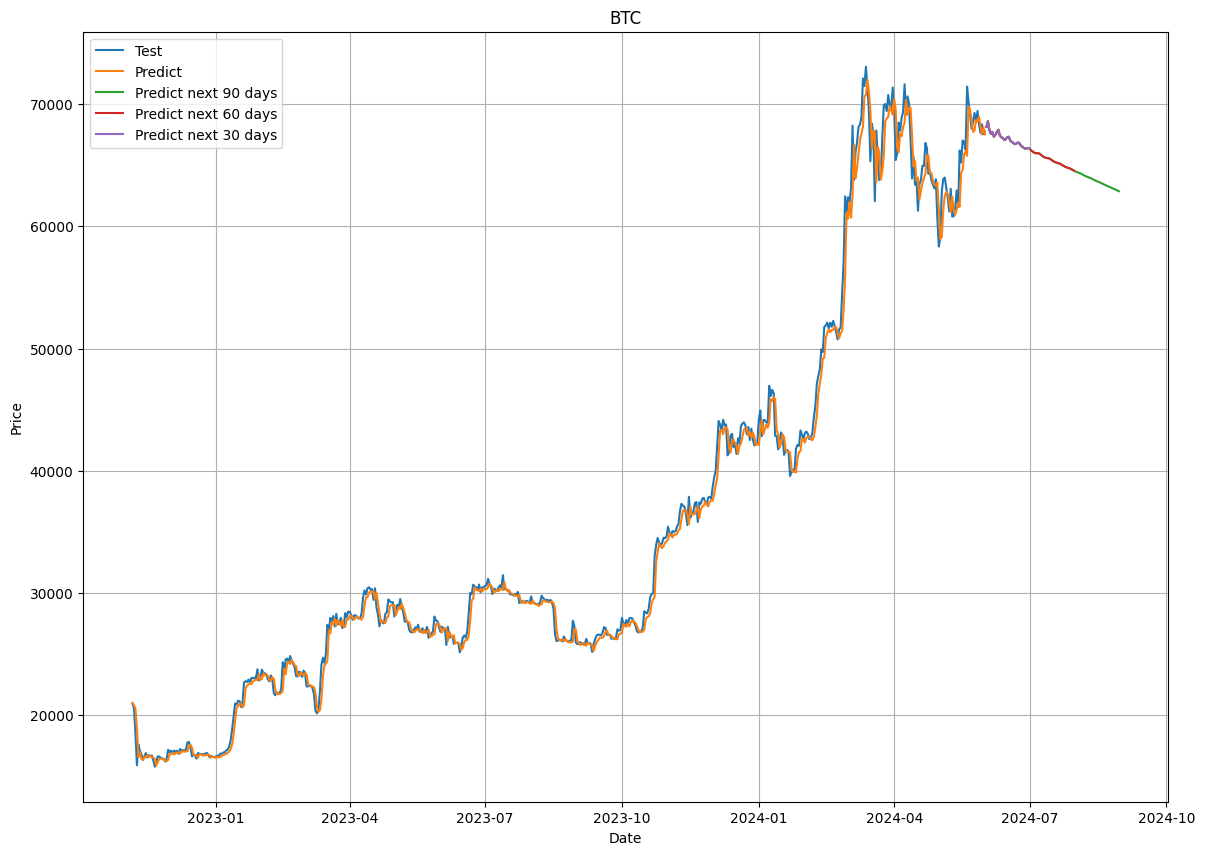

In [16]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(14, 10))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BTC')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 2. ETH/USD Dataset (Data split 7:3)

In [17]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv('../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [19]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [20]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,135.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,132.54,135.31,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,130.45,132.54,135.31,NaN,NaN,NaN,NaN,NaN
2019-03-04,125.76,130.45,132.54,135.31,NaN,NaN,NaN,NaN
2019-03-05,136.59,125.76,130.45,132.54,135.31,NaN,NaN,NaN


In [21]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.7)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [22]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [23]:
split_size1 = int(0.7 * len(price)) 

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [24]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [25]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 6470.3535 - mae: 6470.3535 - mse: 224467296.0000 - val_loss: 5342.2710 - val_mae: 5342.2710 - val_mse: 31657724.0000
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 723ms/step - loss: 2671.7996 - mae: 2671.7996 - mse: 17711850.0000 - val_loss: 6290.8989 - val_mae: 6290.8989 - val_mse: 45208892.0000
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step - loss: 3443.5574 - mae: 3443.5574 - mse: 28096666.0000 - val_loss: 1125.3691 - val_mae: 1125.3691 - val_mse: 1429127.6250
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step - loss: 608.6393 - mae: 608.6393 - mse: 866885.9375 - val_loss: 716.7042 - val_mae: 716.7042 - val_mse: 589181.3125
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step - loss: 419.0512 - mae: 419.0512 - mse: 386933.6875 - val_loss: 246.9837 - val_mae: 246.9837 - val_mse: 85266.5625
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step - loss: 188.9164 - mae: 188.9164 - mse: 107910.2812 - val_loss: 188.7734 - val_mae: 188.7734 

In [26]:
model_preds1 = model.predict(X_test).reshape(-1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.815667549862887
RMSE: 82.98063580025371
MAE: 58.94821398798181


In [28]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [29]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicting on: 
 Date
2024-05-26    3825.90
2024-05-27    3894.21
2024-05-28    3845.56
2024-05-29    3769.65
2024-05-30    3747.91
2024-05-31    3762.59
2024-06-01    3815.93
Name: Price, dtype: float64 -> Prediction: 3892.755126953125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting on: 
 [3894.21       3845.56       3769.65       3747.91       3762.59
 3815.93       3892.75512695] -> Prediction: 3923.974609375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting on: 
 [3845.56       3769.65       3747.91       3762.59       3815.93
 3892.75512695 3923.97460938] -> Prediction: 3894.427978515625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicting on: 
 [3769.65       3747.91       3762.59       3815.93       3892.75512695
 3923.97460938 3894.42797852] -> Prediction: 3848.27392578125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting on: 
 [3747.91       3762.59       3815.93       3892.75512695 3923.97460938
 3894.42797852 3848.27392578] -> Prediction:

In [30]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [31]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

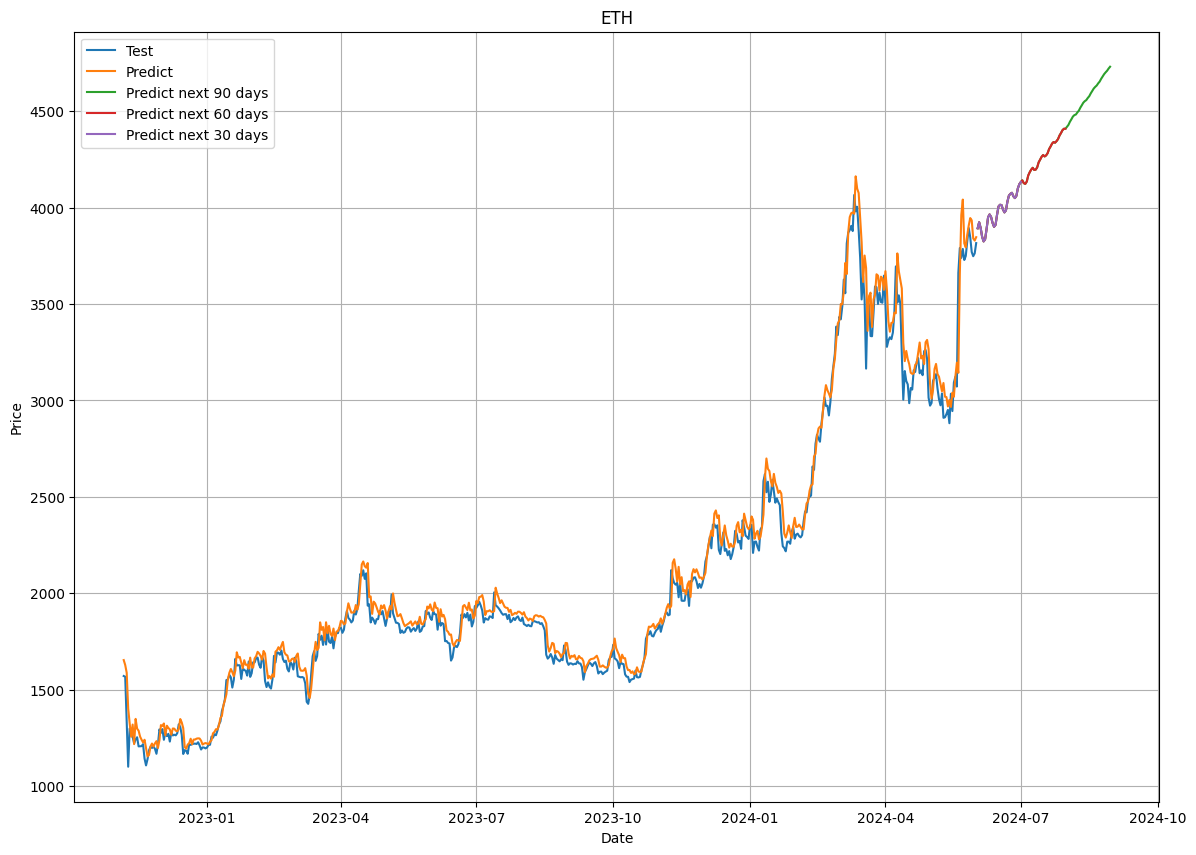

In [32]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(14, 10))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('ETH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 3. BNB/USD Dataset (Data split 7:3)

In [33]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
df = pd.read_csv('../Dataset/BNB_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [35]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [36]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,11.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,11.75,11.35,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,11.45,11.75,11.35,NaN,NaN,NaN,NaN,NaN
2019-03-04,11.41,11.45,11.75,11.35,NaN,NaN,NaN,NaN
2019-03-05,13.65,11.41,11.45,11.75,11.35,NaN,NaN,NaN


In [37]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.7)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [38]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [39]:
split_size1 = int(0.7 * len(price))

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [40]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [41]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 1738.9771 - mae: 1738.9771 - mse: 18974334.0000 - val_loss: 1327.1859 - val_mae: 1327.1859 - val_mse: 1987643.1250
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 470ms/step - loss: 576.6843 - mae: 576.6843 - mse: 896457.5625 - val_loss: 24.2085 - val_mae: 24.2085 - val_mse: 1316.2579
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 475ms/step - loss: 25.9666 - mae: 25.9666 - mse: 2232.5366 - val_loss: 193.7713 - val_mae: 193.7713 - val_mse: 43964.2422
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step - loss: 87.7799 - mae: 87.7799 - mse: 26077.0996 - val_loss: 10.9407 - val_mae: 10.9407 - val_mse: 299.6950
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 494ms/step - loss: 17.5790 - mae: 17.5790 - mse: 1190.5502 - val_loss: 104.2998 - val_mae: 104.2998 - val_mse: 12871.7266
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 477ms/step - loss: 51.9581 - mae: 51.9581 - mse: 7641.5967 - val_loss: 51.4383 - val_mae: 51.4383 - val_mse: 3177.2993
Epoch 7/100
2/2 ━━━━━━━

In [42]:
model_preds1 = model.predict(X_test).reshape(-1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 1.920207125060195
RMSE: 10.880117195955973
MAE: 6.4549926332480405


In [44]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [45]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicting on: 
 Date
2024-05-26    600.3
2024-05-27    603.8
2024-05-28    601.7
2024-05-29    595.6
2024-05-30    595.0
2024-05-31    593.8
2024-06-01    601.8
Name: Price, dtype: float64 -> Prediction: 596.003662109375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting on: 
 [603.8        601.7        595.6        595.         593.8
 601.8        596.00366211] -> Prediction: 599.1681518554688

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting on: 
 [601.7        595.6        595.         593.8        601.8
 596.00366211 599.16815186] -> Prediction: 596.8901977539062

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicting on: 
 [595.6        595.         593.8        601.8        596.00366211
 599.16815186 596.89019775] -> Prediction: 591.8142700195312

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicting on: 
 [595.         593.8        601.8        596.00366211 599.16815186
 596.89019775 591.81427002] -> Prediction: 593.066162109375

1/1 ━━━━━━━━━━━━━━━━━━

In [46]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [47]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

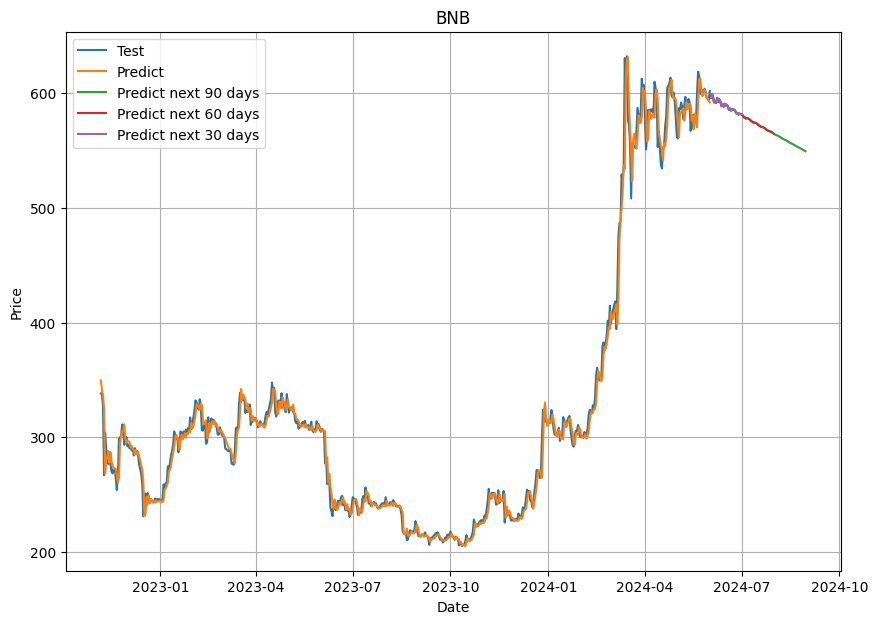

In [48]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(10, 7))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BNB')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 4. BTC/USD Dataset (Data split 8:2)

In [49]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
df = pd.read_csv('../Dataset/BTC_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [51]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [52]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,3823.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN
2019-03-04,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN
2019-03-05,3857.5,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN


In [53]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [54]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [55]:
split_size1 = int(0.8 * len(price))

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [56]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [57]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 184337.4531 - mae: 184337.4531 - mse: 164321443840.0000 - val_loss: 172436.4844 - val_mae: 172436.4844 - val_mse: 33776744448.0000
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 763ms/step - loss: 79798.3125 - mae: 79798.3125 - mse: 12025358336.0000 - val_loss: 20850.0645 - val_mae: 20850.0645 - val_mse: 503220544.0000
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step - loss: 9399.1396 - mae: 9399.1396 - mse: 190707856.0000 - val_loss: 13357.8691 - val_mae: 13357.8691 - val_mse: 206787616.0000
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 856ms/step - loss: 13990.7773 - mae: 13990.7773 - mse: 420729408.0000 - val_loss: 13300.4160 - val_mae: 13300.4160 - val_mse: 211043504.0000
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 774ms/step - loss: 7077.1665 - mae: 7077.1665 - mse: 88899176.0000 - val_loss: 7580.0811 - val_mae: 7580.0811 - val_mse: 69977248.0000
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 763ms/step - loss: 4099.4810 - mae: 4099.4810 - mse: 3

In [60]:
model_preds1 = model.predict(X_test).reshape(-1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 1.909717159165179
RMSE: 1310.5650713478958
MAE: 853.9390747389032


In [62]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [63]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicting on: 
 Date
2024-05-26    68520.1
2024-05-27    69440.0
2024-05-28    68374.0
2024-05-29    67652.4
2024-05-30    68352.2
2024-05-31    67548.0
2024-06-01    67768.5
Name: Price, dtype: float64 -> Prediction: 69254.9375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting on: 
 [69440.     68374.     67652.4    68352.2    67548.     67768.5
 69254.9375] -> Prediction: 69627.84375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicting on: 
 [68374.      67652.4     68352.2     67548.      67768.5     69254.9375
 69627.84375] -> Prediction: 68902.296875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting on: 
 [67652.4      68352.2      67548.       67768.5      69254.9375
 69627.84375  68902.296875] -> Prediction: 68486.765625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicting on: 
 [68352.2      67548.       67768.5      69254.9375   69627.84375
 68902.296875 68486.765625] -> Prediction: 68831.2109375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predictin

In [64]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [65]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

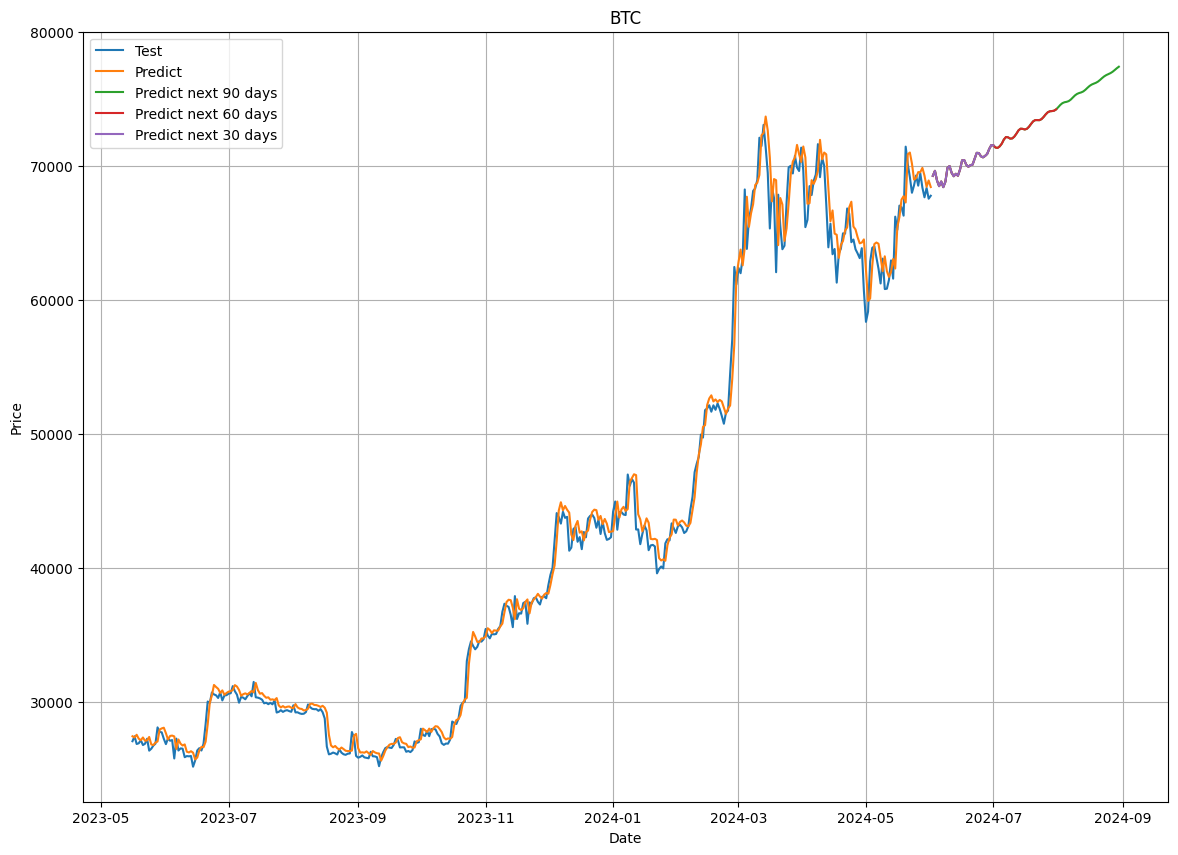

In [66]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(14, 10))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BTC')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 5. ETH/USD Dataset (Data split 8:2)

In [67]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [68]:
df = pd.read_csv('../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [69]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [70]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,135.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,132.54,135.31,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,130.45,132.54,135.31,NaN,NaN,NaN,NaN,NaN
2019-03-04,125.76,130.45,132.54,135.31,NaN,NaN,NaN,NaN
2019-03-05,136.59,125.76,130.45,132.54,135.31,NaN,NaN,NaN


In [71]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [72]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [73]:
split_size1 = int(0.8 * len(price))

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [74]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [75]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - loss: 10310.9717 - mae: 10310.9717 - mse: 499615488.0000 - val_loss: 7258.1763 - val_mae: 7258.1763 - val_mse: 57293908.0000
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step - loss: 3287.5444 - mae: 3287.5444 - mse: 24941610.0000 - val_loss: 121.5811 - val_mae: 121.5811 - val_mse: 30685.4238
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step - loss: 195.0444 - mae: 195.0444 - mse: 102556.7266 - val_loss: 405.4731 - val_mae: 405.4731 - val_mse: 188716.0938
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step - loss: 353.6352 - mae: 353.6352 - mse: 287750.9688 - val_loss: 116.2494 - val_mae: 116.2494 - val_mse: 21509.0801
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step - loss: 138.2443 - mae: 138.2443 - mse: 60025.9414 - val_loss: 89.7607 - val_mae: 89.7607 - val_mse: 17184.5723
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step - loss: 76.8315 - mae: 76.8315 - mse: 22946.9766 - val_loss: 450.1084 - val_mae: 450.1084 - val_mse: 231892

In [76]:
model_preds1 = model.predict(X_test).reshape(-1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step


In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.12689622185003
RMSE: 81.95809226489524
MAE: 53.07148878610476


In [78]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [79]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicting on: 
 Date
2024-05-26    3825.90
2024-05-27    3894.21
2024-05-28    3845.56
2024-05-29    3769.65
2024-05-30    3747.91
2024-05-31    3762.59
2024-06-01    3815.93
Name: Price, dtype: float64 -> Prediction: 3794.03369140625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting on: 
 [3894.21       3845.56       3769.65       3747.91       3762.59
 3815.93       3794.03369141] -> Prediction: 3835.915283203125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicting on: 
 [3845.56       3769.65       3747.91       3762.59       3815.93
 3794.03369141 3835.9152832 ] -> Prediction: 3777.455078125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicting on: 
 [3769.65       3747.91       3762.59       3815.93       3794.03369141
 3835.9152832  3777.45507812] -> Prediction: 3725.095947265625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicting on: 
 [3747.91       3762.59       3815.93       3794.03369141 3835.9152832
 3777.45507812 3725.09594727] -> Prediction: 

In [80]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [81]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

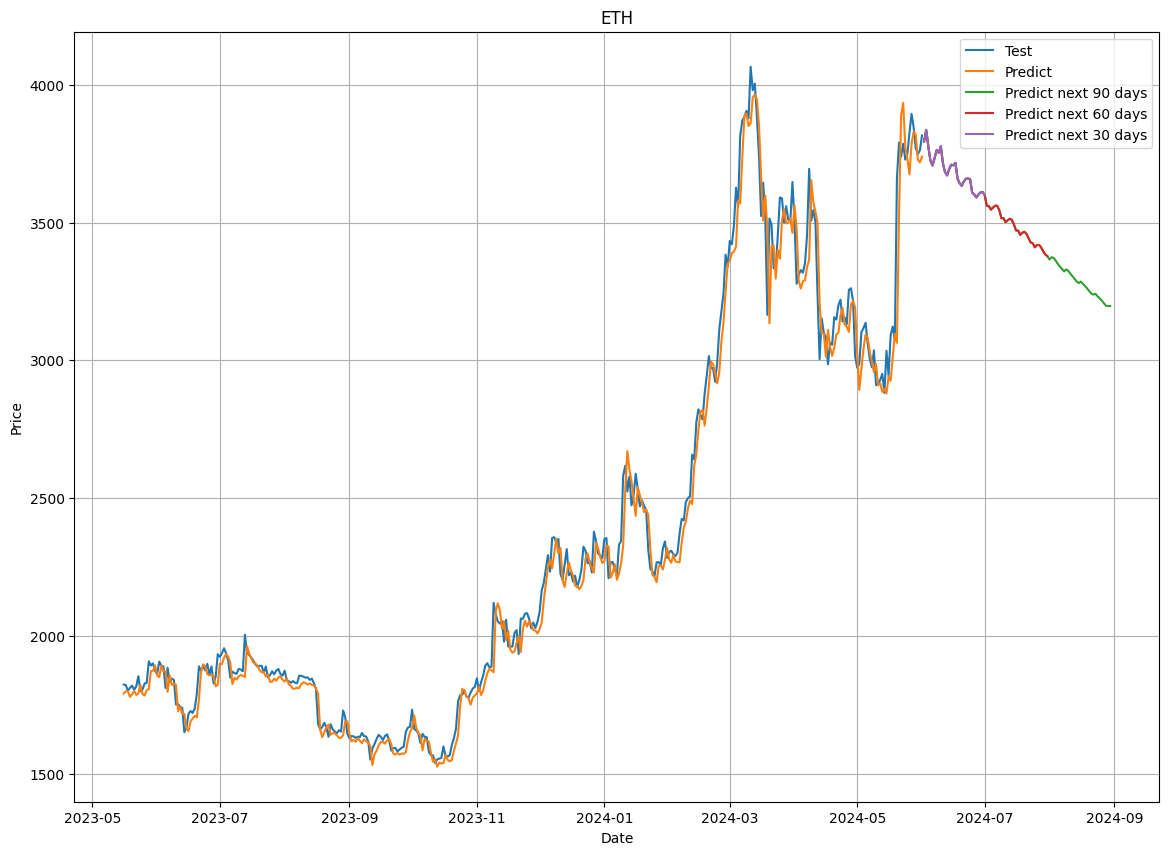

In [82]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(14, 10))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('ETH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 6. BNB/USD Dataset (Data split 8:2)

In [83]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [84]:
df = pd.read_csv('../Dataset/BNB_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [85]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [86]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,11.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,11.75,11.35,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,11.45,11.75,11.35,NaN,NaN,NaN,NaN,NaN
2019-03-04,11.41,11.45,11.75,11.35,NaN,NaN,NaN,NaN
2019-03-05,13.65,11.41,11.45,11.75,11.35,NaN,NaN,NaN


In [87]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [88]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [89]:
split_size1 = int(0.8 * len(price))

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [90]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [91]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 1151.3943 - mae: 1151.3943 - mse: 5197480.5000 - val_loss: 981.9128 - val_mae: 981.9128 - val_mse: 1132196.3750
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step - loss: 432.2199 - mae: 432.2199 - mse: 463311.4688 - val_loss: 24.5130 - val_mae: 24.5130 - val_mse: 1549.5344
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step - loss: 37.7866 - mae: 37.7866 - mse: 4637.2134 - val_loss: 16.0453 - val_mae: 16.0453 - val_mse: 520.8010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step - loss: 23.0071 - mae: 23.0071 - mse: 1558.4960 - val_loss: 226.9180 - val_mae: 226.9180 - val_mse: 61632.3359
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step - loss: 111.8501 - mae: 111.8501 - mse: 30214.1934 - val_loss: 78.3340 - val_mae: 78.3340 - val_mse: 7662.4229
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step - loss: 33.9501 - mae: 33.9501 - mse: 4352.6284 - val_loss: 41.9546 - val_mae: 41.9546 - val_mse: 2312.7637
Epoch 7/100
2/2 ━━━━━━━━━━━

In [92]:
model_preds1 = model.predict(X_test).reshape(-1)
model_preds1[:10]

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step


array([313.76508, 313.13507, 314.232  , 311.93845, 310.2913 , 310.99762,
       309.2885 , 309.48053, 312.50757, 309.34048], dtype=float32)

In [93]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 1.9034973575705685
RMSE: 11.64782588775198
MAE: 6.822507925008668


In [94]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [95]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicting on: 
 Date
2024-05-26    600.3
2024-05-27    603.8
2024-05-28    601.7
2024-05-29    595.6
2024-05-30    595.0
2024-05-31    593.8
2024-06-01    601.8
Name: Price, dtype: float64 -> Prediction: 603.4127807617188

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicting on: 
 [603.8        601.7        595.6        595.         593.8
 601.8        603.41278076] -> Prediction: 604.4176635742188

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicting on: 
 [601.7        595.6        595.         593.8        601.8
 603.41278076 604.41766357] -> Prediction: 601.76123046875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicting on: 
 [595.6        595.         593.8        601.8        603.41278076
 604.41766357 601.76123047] -> Prediction: 597.3843383789062

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicting on: 
 [595.         593.8        601.8        603.41278076 604.41766357
 601.76123047 597.38433838] -> Prediction: 595.9591064453125

1/1 ━━━━━━━━━━━━━━━━━━

In [96]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [97]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

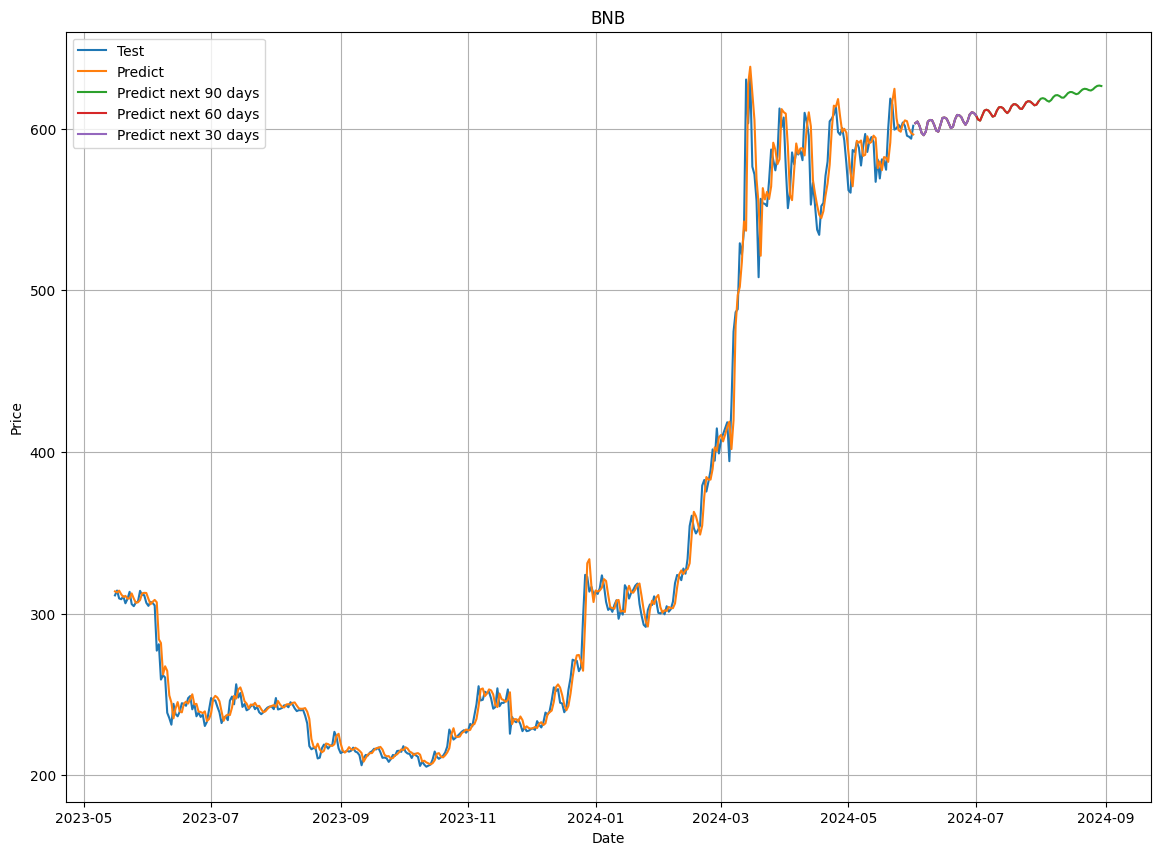

In [98]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(14, 10))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BNB')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 7. BTC/USD Dataset (Data split 9:1)

In [99]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [100]:
df = pd.read_csv('../Dataset/BTC_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [101]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [102]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,3823.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN,NaN
2019-03-04,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN,NaN
2019-03-05,3857.5,3715.0,3806.4,3820.0,3823.2,NaN,NaN,NaN


In [103]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [104]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [105]:
split_size1 = int(0.9 * len(price)) 

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [106]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [107]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - loss: 119231.2031 - mae: 119231.2031 - mse: 38572638208.0000 - val_loss: 127449.2734 - val_mae: 127449.2734 - val_mse: 17067987968.0000
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 43892.1758 - mae: 43892.1758 - mse: 3731765248.0000 - val_loss: 43264.7773 - val_mae: 43264.7773 - val_mse: 1979210368.0000
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 17784.2324 - mae: 17784.2324 - mse: 503257152.0000 - val_loss: 24332.3613 - val_mae: 24332.3613 - val_mse: 624097984.0000
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 10907.2285 - mae: 10907.2285 - mse: 191334896.0000 - val_loss: 6813.0469 - val_mae: 6813.0469 - val_mse: 57684692.0000
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 9121.7686 - mae: 9121.7686 - mse: 219782544.0000 - val_loss: 3193.6121 - val_mae: 3193.6121 - val_mse: 14463848.0000
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 975ms/step - loss: 4316.3613 - mae: 4316.3613 - mse: 44124724.0000 

In [108]:
model_preds1 = model.predict(X_test).reshape(-1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [109]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.164699565292739
RMSE: 1737.1697349296157
MAE: 1222.9379720052082


In [110]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [111]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicting on: 
 Date
2024-05-26    68520.1
2024-05-27    69440.0
2024-05-28    68374.0
2024-05-29    67652.4
2024-05-30    68352.2
2024-05-31    67548.0
2024-06-01    67768.5
Name: Price, dtype: float64 -> Prediction: 68508.8046875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicting on: 
 [69440.        68374.        67652.4       68352.2       67548.
 67768.5       68508.8046875] -> Prediction: 68442.609375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicting on: 
 [68374.        67652.4       68352.2       67548.        67768.5
 68508.8046875 68442.609375 ] -> Prediction: 68077.2109375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicting on: 
 [67652.4       68352.2       67548.        67768.5       68508.8046875
 68442.609375  68077.2109375] -> Prediction: 67774.6015625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicting on: 
 [68352.2       67548.        67768.5       68508.8046875 68442.609375
 68077.2109375 67774.6015625] -> Prediction: 67671.5859375

1

In [112]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [113]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

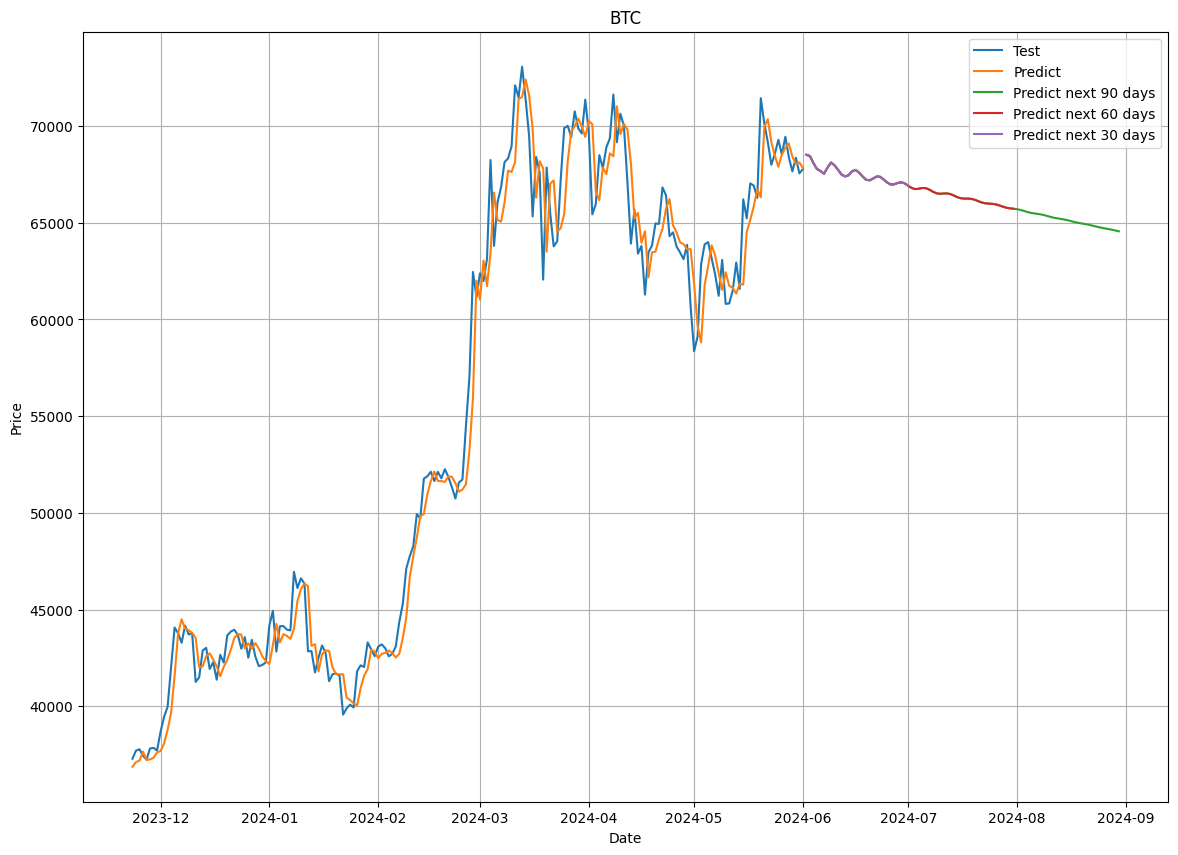

In [114]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(14, 10))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BTC')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 8. ETH/USD Dataset (Data split 9:1)

In [115]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [116]:
df = pd.read_csv('../Dataset/ETH_USD-Binance-Historical-Data-1_New.csv')
df = df.sort_index(ascending=False)
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [117]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [118]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,135.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,132.54,135.31,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,130.45,132.54,135.31,NaN,NaN,NaN,NaN,NaN
2019-03-04,125.76,130.45,132.54,135.31,NaN,NaN,NaN,NaN
2019-03-05,136.59,125.76,130.45,132.54,135.31,NaN,NaN,NaN


In [119]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [120]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [121]:
split_size1 = int(0.9 * len(price)) 

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [122]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [123]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 6914.6475 - mae: 6914.6475 - mse: 139316928.0000 - val_loss: 6212.2046 - val_mae: 6212.2046 - val_mse: 40228096.0000
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step - loss: 2158.8582 - mae: 2158.8582 - mse: 11255377.0000 - val_loss: 1096.4989 - val_mae: 1096.4989 - val_mse: 1351242.6250
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step - loss: 528.8401 - mae: 528.8401 - mse: 603449.0625 - val_loss: 199.5409 - val_mae: 199.5409 - val_mse: 55117.1758
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step - loss: 177.9975 - mae: 177.9975 - mse: 75517.4219 - val_loss: 387.5530 - val_mae: 387.5530 - val_mse: 178322.4375
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step - loss: 196.1418 - mae: 196.1418 - mse: 94595.6719 - val_loss: 139.8819 - val_mae: 139.8819 - val_mse: 32488.7832
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 710ms/step - loss: 113.7056 - mae: 113.7056 - mse: 30357.1191 - val_loss: 238.9853 - val_mae: 238.9853 - val_mse: 8

In [124]:
model_preds1 = model.predict(X_test).reshape(-1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [125]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.4637564251685355
RMSE: 107.35674275361562
MAE: 73.0204400126139


In [126]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [127]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step
Predicting on: 
 Date
2024-05-26    3825.90
2024-05-27    3894.21
2024-05-28    3845.56
2024-05-29    3769.65
2024-05-30    3747.91
2024-05-31    3762.59
2024-06-01    3815.93
Name: Price, dtype: float64 -> Prediction: 3847.828125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicting on: 
 [3894.21     3845.56     3769.65     3747.91     3762.59     3815.93
 3847.828125] -> Prediction: 3881.39453125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting on: 
 [3845.56       3769.65       3747.91       3762.59       3815.93
 3847.828125   3881.39453125] -> Prediction: 3847.799560546875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicting on: 
 [3769.65       3747.91       3762.59       3815.93       3847.828125
 3881.39453125 3847.79956055] -> Prediction: 3809.389404296875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting on: 
 [3747.91       3762.59       3815.93       3847.828125   3881.39453125
 3847.79956055 3809.3894043 ] -> Prediction: 3804.500244140625


In [128]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [129]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

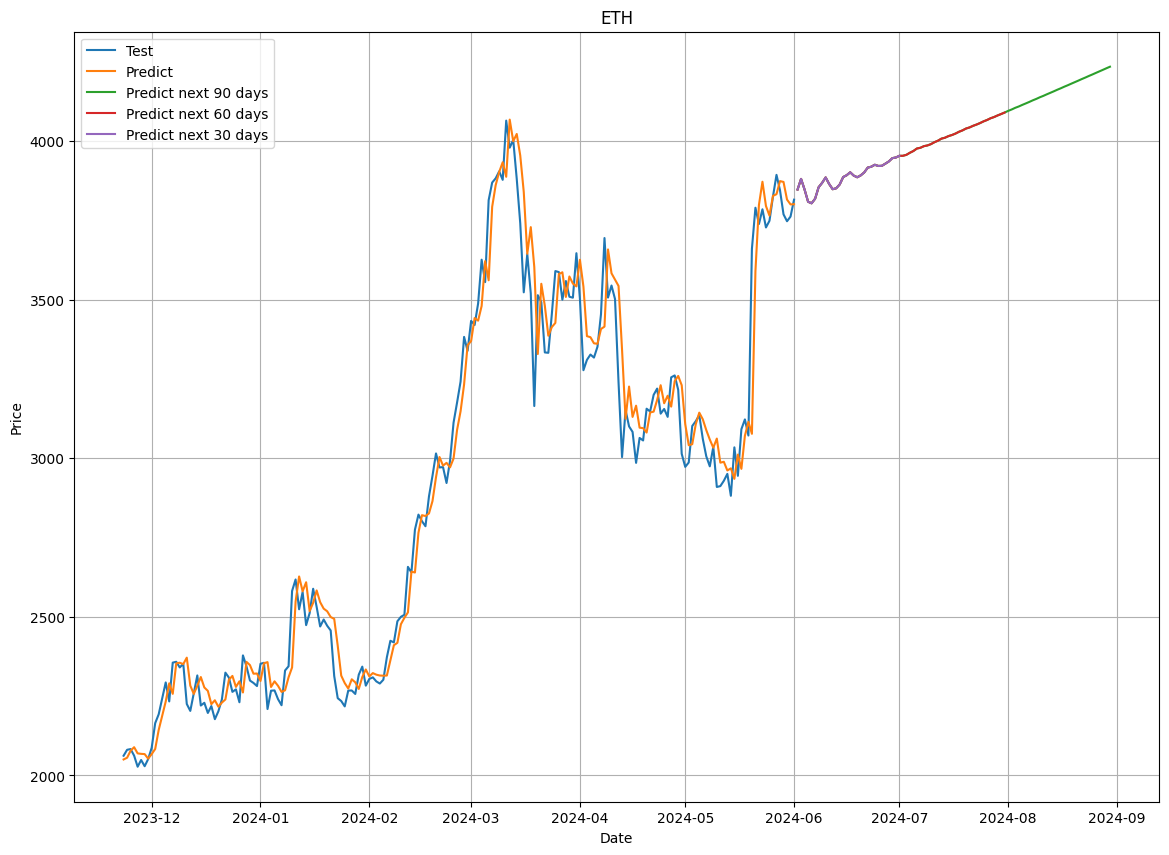

In [130]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(14, 10))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')

plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('ETH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 9. BNB/USD Dataset (Data split 9:1)

In [131]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [132]:
df = pd.read_csv('../Dataset/BNB_USD-Binance-Historical-Data_New.csv')
df = df.sort_index(ascending=False)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]

In [133]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): 
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [134]:
HORIZON = 1 
WINDOW_SIZE = 7 
prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  prices_nbeats[f"Price+{i+1}"] = prices_nbeats["Price"].shift(periods=i+1)
prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-01,11.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-02,11.75,11.35,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,11.45,11.75,11.35,NaN,NaN,NaN,NaN,NaN
2019-03-04,11.41,11.45,11.75,11.35,NaN,NaN,NaN,NaN
2019-03-05,13.65,11.41,11.45,11.75,11.35,NaN,NaN,NaN


In [135]:
X = prices_nbeats.dropna().drop("Price", axis=1)
y = prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]


In [136]:
df1 = prices_nbeats.dropna()

timesteps = []
price = []

for line in df1['Price']:
    price.append(line) 
for line in df1.index:
    timesteps.append(line) 

In [137]:
split_size1 = int(0.9 * len(price)) 

X_train1, y_train1 = timesteps[:split_size1], price[:split_size1]
X_test1, y_test1 = timesteps[split_size1:], price[split_size1:]

In [138]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [139]:
N_EPOCHS = 100
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON 
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

for i, _ in enumerate(range(N_STACKS-1)): 
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 1408.4895 - mae: 1408.4895 - mse: 6453569.0000 - val_loss: 1213.8414 - val_mae: 1213.8414 - val_mse: 1650611.3750
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step - loss: 380.0835 - mae: 380.0835 - mse: 390135.6875 - val_loss: 267.6424 - val_mae: 267.6424 - val_mse: 85332.1328
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 448ms/step - loss: 111.3890 - mae: 111.3890 - mse: 32285.8066 - val_loss: 96.1340 - val_mae: 96.1340 - val_mse: 10871.3525
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step - loss: 55.8151 - mae: 55.8151 - mse: 6512.2397 - val_loss: 33.3511 - val_mae: 33.3511 - val_mse: 1578.0004
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 476ms/step - loss: 12.5739 - mae: 12.5739 - mse: 673.4891 - val_loss: 27.6738 - val_mae: 27.6738 - val_mse: 1050.1868
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step - loss: 16.5266 - mae: 16.5266 - mse: 727.8284 - val_loss: 65.0111 - val_mae: 65.0111 - val_mse: 4916.0513
Epoch 7/100
2/2 ━━━━━━━━━

In [140]:
model_preds1 = model.predict(X_test).reshape(-1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [141]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_test2 = np.array(y_test.tolist())

mape = np.mean(np.abs((y_test2 - model_preds1) / y_test2)) * 100
mse = mean_squared_error(y_test2, model_preds1)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test2,model_preds1)

print("MAPE:", mape )
print("RMSE:", rmse)
print("MAE:", mae)

MAPE: 2.44215192195073
RMSE: 16.2482976525364
MAE: 10.766543292999266


In [142]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] 

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [143]:
INTO_FUTURE = 90 
future_forecast = make_future_forecast(values=y_test,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
Predicting on: 
 Date
2024-05-26    600.3
2024-05-27    603.8
2024-05-28    601.7
2024-05-29    595.6
2024-05-30    595.0
2024-05-31    593.8
2024-06-01    601.8
Name: Price, dtype: float64 -> Prediction: 593.0446166992188

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicting on: 
 [603.8       601.7       595.6       595.        593.8       601.8
 593.0446167] -> Prediction: 594.4666137695312

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicting on: 
 [601.7        595.6        595.         593.8        601.8
 593.0446167  594.46661377] -> Prediction: 591.6542358398438

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting on: 
 [595.6        595.         593.8        601.8        593.0446167
 594.46661377 591.65423584] -> Prediction: 587.9083862304688

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting on: 
 [595.         593.8        601.8        593.0446167  594.46661377
 591.65423584 587.90838623] -> Prediction: 588.1371459960938

1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [144]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D") 
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [145]:
last_timestep = df.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)

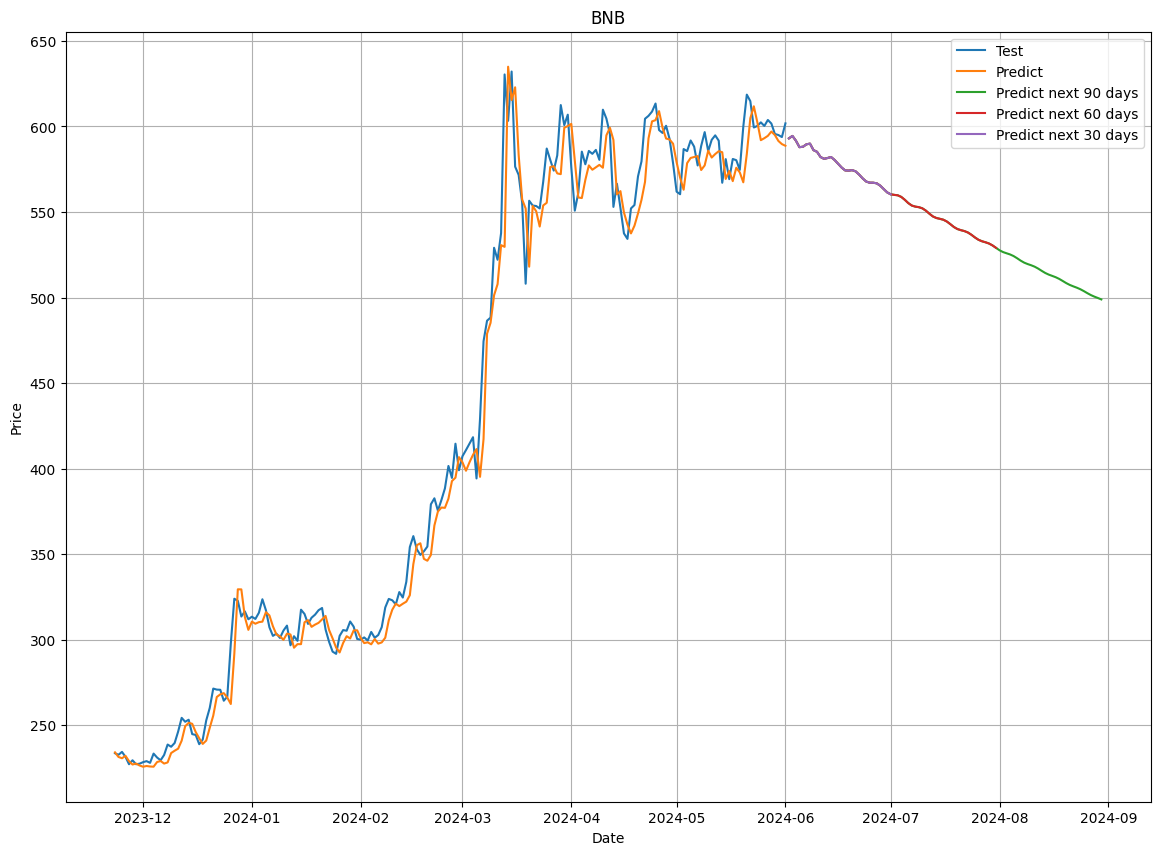

In [146]:
# Visualize time series of actual and predicted values
plt.figure(figsize=(14, 10))
#plt.plot(X_train1, y_train1, linestyle='-', label='Train')
plt.plot(X_test1, y_test1, linestyle='-', label='Test')
plt.plot(X_test1, model_preds1, linestyle='-', label='Predict')

plt.plot(next_time_steps[-90:], future_forecast[-90:], linestyle='-', label='Predict next 90 days')
plt.plot(next_time_steps[:60], future_forecast[:60], linestyle='-', label='Predict next 60 days')
plt.plot(next_time_steps[:30], future_forecast[:30], linestyle='-', label='Predict next 30 days')
plt.title('BNB')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()